## Summary


GAMENet is a model that focuses on drug recommendation. However, instead of purely finding the optimal drugs to recommend based on a patient, GAMENet also uses EHR and Drug-to-Drug interaction knowledge graphs to tailor its recommendations based on potential adverse drug-to-drug interactions that may occur. The model uses these knowledge graphs as well as a dynamic memory module to augment its input with additional information to reduce adverse drug interactions while still allowing for accurate recommendations.

In our paper, we wanted to reproduce the model's results for GAMENet, with and without DDI. Additionally, we wanted to determine whether or not the Dynamic memory module played a significant role in the predictive task. Lastly, we wanted to see if there was any loss or gain in the effectiveness of the model if we replaced the knowledge graphs' implementation from a GCN with a GAT.

We were not able to completely reproduce the model's metrics, even after matching the Python and Library versions precisely. Our model had a worse DDI Rate but carried a slight improvement in all predictive metrics. This was consistent with DDI and without.
Removing the dynamic memory caused a significant reduction in DDI Rate and the other predictive metrics.

Finally, replacing the GCN with a GAT slightly increased the DDI Rate but resulted in notable increases in the predictive metrics.

# Exploratory Analysis

First we need to gather preliminary statistics about the data. We will be using PyHealth to do so.

In [56]:
from pyhealth.datasets import MIMIC3Dataset
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
dataset = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PRESCRIPTIONS", "PROCEDURES_ICD"],
        code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
    )

Mapping codes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49993/49993 [00:44<00:00, 1134.12it/s]


In [83]:
dataset.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 49993
	- Number of visits: 52769
	- Number of visits per patient: 1.0555
	- Number of events per visit in DIAGNOSES_ICD: 9.1038
	- Number of events per visit in PRESCRIPTIONS: 32.9969
	- Number of events per visit in PROCEDURES_ICD: 3.2186



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 49993\n\t- Number of visits: 52769\n\t- Number of visits per patient: 1.0555\n\t- Number of events per visit in DIAGNOSES_ICD: 9.1038\n\t- Number of events per visit in PRESCRIPTIONS: 32.9969\n\t- Number of events per visit in PROCEDURES_ICD: 3.2186\n'

In [86]:
def gamenet_drug_task_mimic3(patient):
    
    samples = []
    for visit_idx in range(len(patient) - 1):
        visit = patient[visit_idx]
        
        diagnostic_code = visit.get_code_list(table="DIAGNOSES_ICD")
        procedure_code = visit.get_code_list(table="PROCEDURES_ICD")
        drug_code = visit.get_code_list(table="PRESCRIPTIONS")
        
        samples.append(
        {
            "patient_id": patient.patient_id,
            "visit_id": visit.visit_id,
            "ICD9_CODE": diagnostic_code,
            "NDC": drug_code,
            "PRO_CODE": procedure_code,
            "NDC_Len": len(drug_code)
        })
    
    return samples
    

In [87]:
gamenet_dataset = dataset.set_task(gamenet_drug_task_mimic3)

Generating samples for gamenet_drug_task_mimic3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 49993/49993 [00:00<00:00, 362561.23it/s]


In [88]:
gamenet_dataset.stat()

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: gamenet_drug_task_mimic3
	- Number of samples: 2776
	- Number of patients: 2339
	- Number of visits: 2776
	- Number of visits per patient: 1.1868
	- ICD9_CODE:
		- Number of ICD9_CODE per sample: 9.0865
		- Number of unique ICD9_CODE: 2650
		- Distribution of ICD9_CODE (Top-10): [('4019', 972), ('41401', 624), ('42731', 597), ('25000', 544), ('4280', 523), ('2724', 360), ('5849', 328), ('53081', 326), ('2720', 308), ('5990', 300)]
	- NDC:
		- Number of NDC per sample: 18.8015
		- Number of unique NDC: 181
		- Distribution of NDC (Top-10): [('B05X', 1881), ('A06A', 1748), ('N02A', 1652), ('N02B', 1640), ('A02B', 1628), ('B01A', 1614), ('C07A', 1452), ('V06D', 1448), ('A12B', 1255), ('V04C', 1192)]
	- PRO_CODE:
		- Number of PRO_CODE per sample: 3.2385
		- Number of unique PRO_CODE: 817
		- Distribution of PRO_CODE (Top-10): [('3893', 458), ('3961', 426), ('9904', 393), ('8856', 253), ('3615', 235), ('9604', 222), ('966', 2

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: gamenet_drug_task_mimic3\n\t- Number of samples: 2776\n\t- Number of patients: 2339\n\t- Number of visits: 2776\n\t- Number of visits per patient: 1.1868\n\t- ICD9_CODE:\n\t\t- Number of ICD9_CODE per sample: 9.0865\n\t\t- Number of unique ICD9_CODE: 2650\n\t\t- Distribution of ICD9_CODE (Top-10): [('4019', 972), ('41401', 624), ('42731', 597), ('25000', 544), ('4280', 523), ('2724', 360), ('5849', 328), ('53081', 326), ('2720', 308), ('5990', 300)]\n\t- NDC:\n\t\t- Number of NDC per sample: 18.8015\n\t\t- Number of unique NDC: 181\n\t\t- Distribution of NDC (Top-10): [('B05X', 1881), ('A06A', 1748), ('N02A', 1652), ('N02B', 1640), ('A02B', 1628), ('B01A', 1614), ('C07A', 1452), ('V06D', 1448), ('A12B', 1255), ('V04C', 1192)]\n\t- PRO_CODE:\n\t\t- Number of PRO_CODE per sample: 3.2385\n\t\t- Number of unique PRO_CODE: 817\n\t\t- Distribution of PRO_CODE (Top-10): [('3893', 458), ('3961', 426), ('9904', 393), ('8856',

Above is the exploratory stats for the MIMIC 3 dataset. The results differ slightly from the paper, this may be due to differences in the underlying dataset used. The paper only references a pickled version of the data and doesn't point directly to the main underlying data. None the less, for initial exploration, this will do.

In [89]:
gamenet_df = pd.DataFrame(list(gamenet_dataset))
gamenet_df.head()

,patient_id,visit_id,ICD9_CODE,NDC,PRO_CODE,NDC_Len
0,10009,110342,"[5789, 2724, 45620, 78659, 45981, 81601, 5848]","[A02B, N02A, B01A, A04A, A12B, A06A, N06A]",[4516],7
1,10024,110358,"[51881, 4280, 42731, 41401, 496, 2867, 41091, ...","[V06D, C01C, N01A, A12A, C10A, A06A, J01X, N02...","[9672, 3961, 8856, 3404, 0013, 3749]",31
2,10025,110360,"[2720, 5070, 42731, 41401, V4581, 5119, 43820,...","[N06D, H02A, N02B, B01A, N04A, C10A, G04C, A10B]",[3521],8
3,10051,110387,"[4019, 25000, 2449, 1985, 27730, V1042, 80326]","[N02A, A12B, B05B, B05X]",[],4
4,10092,110429,"[53081, 5715, 5185, 5180, 1623, 5672, 8748, 78...","[A06A, N02A, B01A, A04A, C09A]",[3409],5


## Illustration of Results

Below you can see a summary of our results.

In [90]:
results = pd.read_csv('results.csv').set_index('Methods')
results

,DDI Rate,△ DDI Rate %,Jaccard,PR-AUC,F1
Methods,,,,,
Nearest (from ours),0.0791,+1.80%,0.3911,0.3805,0.5465
RETAIN (from ours),0.0829,+6.69%,0.4175,0.6644,0.5789
GameNet (w/o DDI from ours),0.0867,+11.58%,0.4499,0.6906,0.6075
GameNet (from ours),0.0791,+1.80%,0.4523,0.6910,0.6093
GameNet (w/o DDI & DM by Zero Input),0.0804,+3.47%,0.4483,0.6894,0.6061
GameNet (w/o DDI & DM by Remove Input),0.0843,+8.49%,0.4452,0.6855,0.6030
GameNet (w/o DM by Zero Input),0.0849,+9.27%,0.4495,0.6909,0.6070
GameNet (w/o DM by Remove Input),0.0851,+9.52%,0.4458,0.6901,0.6035
GameNet (w/o DDI & GAT),0.0856,+10.17%,0.4504,0.6883,0.6081


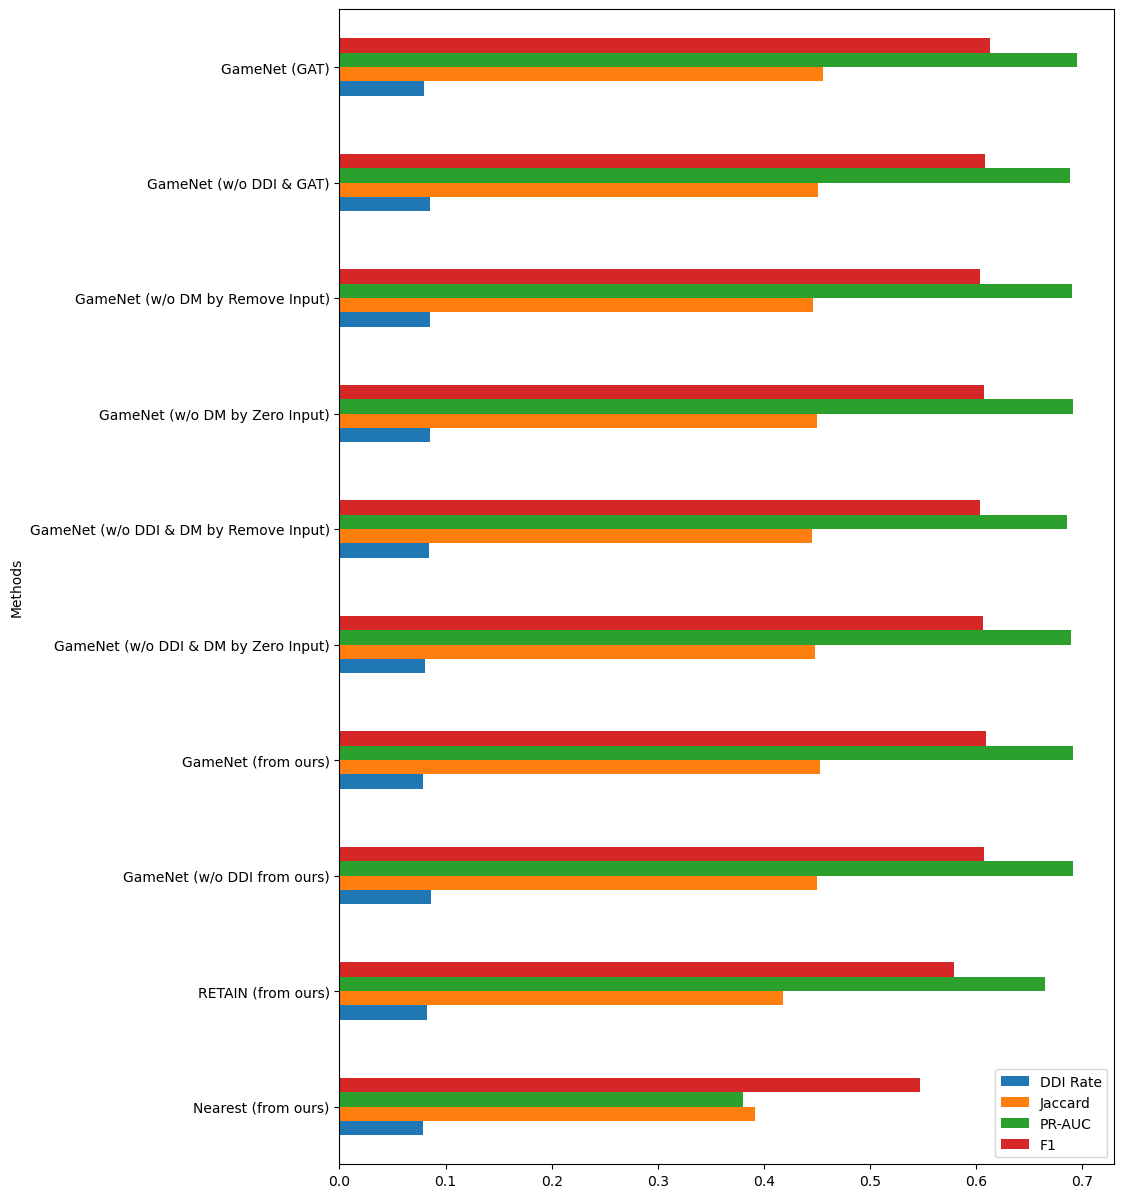

In [91]:
fig, ax = plt.subplots(figsize=(10, 15))
ax = results.plot.barh(ax=ax)
plt.show()

As the plot above clearly illustrates, when it comes to predictive metrics, GAMENet exceeds the other models regardless of the ablation done. Across GAMENet models, the predictive metrics are mostly the same, however a closer inspection of DDI rate displays there is quite a bit difference.

DDI Rate with GAT and GCN are quite lower than the others.

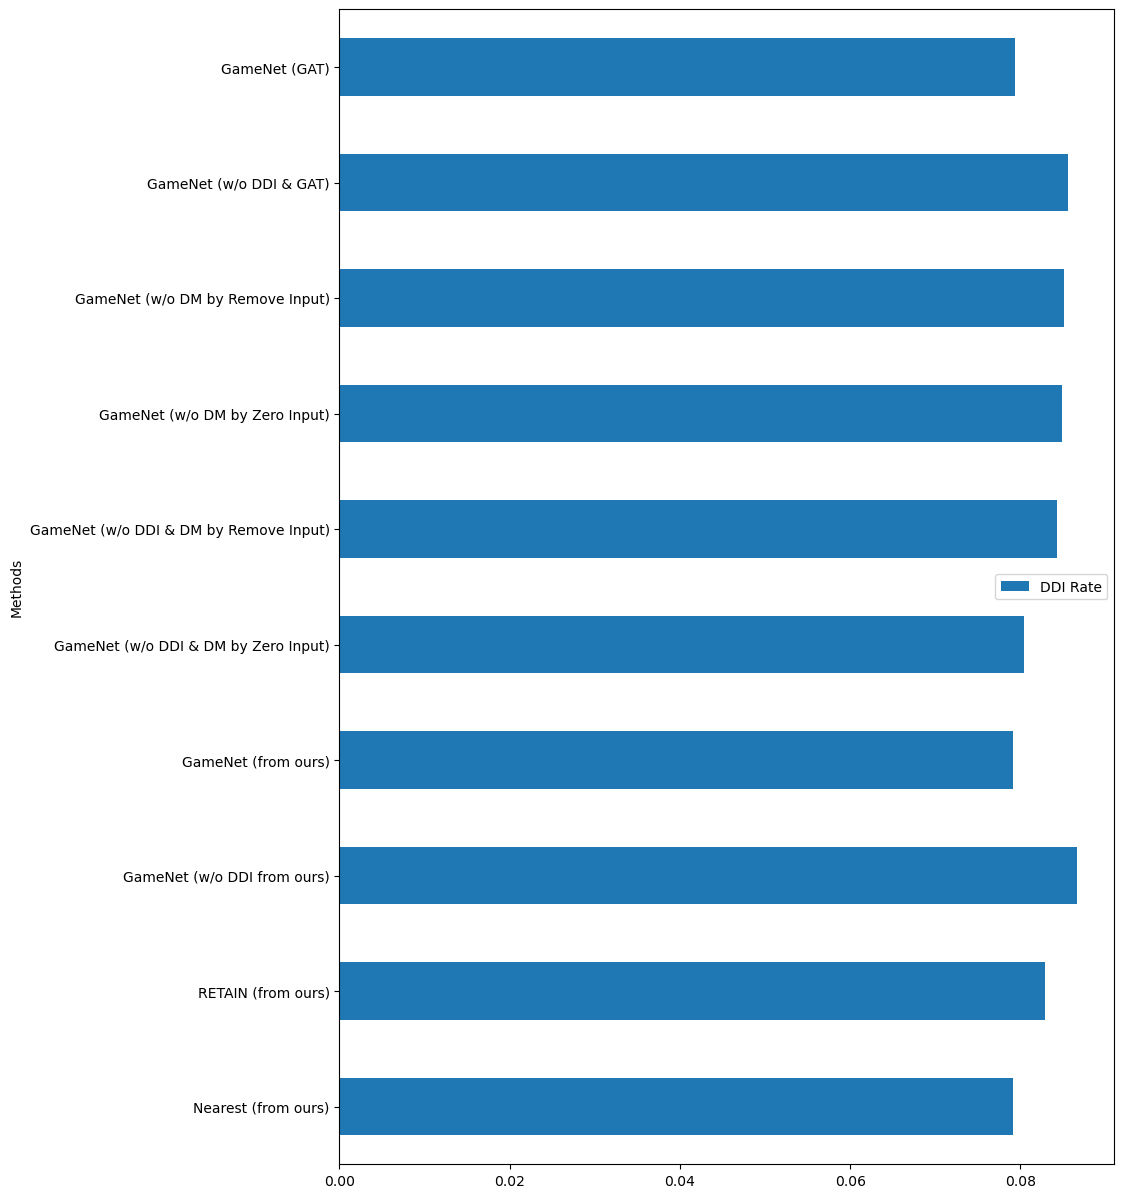

In [92]:
fig, ax = plt.subplots(figsize=(10, 15))
ax = results[['DDI Rate']].plot.barh(ax=ax)
plt.show()